# SwinUnet With Sentinel 1 


## Content

1. [Installation](#installation)
1. [Dataset](#dataset)
1. [Quick Start](#quickstart)

<a id='installation'></a>
## 1. Installation

#### Dependencies

This project uses Python 3.8, and the dependencies listed in `requirements.txt` can be installed with `pip` or `conda`, in a virtual environment. For example, using `pip`:


In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import sys
path_to_module_1 = '/content/drive/My Drive/LandCover_map_Transformers_SSL/src'
sys.path.append(path_to_module_1)

In [ ]:
'''!pip install albumentations==1.1.0
!pip install apex==0.1
!pip install diffdist==0.1
!pip install numpy==1.21.4
!pip install pandas==1.3.4
!pip install rasterio==1.2.10
!pip install termcolor==1.1.0
!pip install timm.egg==info
!pip install torch==1.11.0a0+b6df043
!pip install torchvision==0.11.0a0
!pip install tqdm==4.62.3 
!pip install matplotlib==3.5.2
!pip install scikit-image==0.19.3
!pip install pillow==9.3.0
!pip install pytorch==1.12.1
!pip install torchmetrics==0.10.0
!pip install pytorch-lightning==1.8
!pip install segmentation-models-pytorch==0.3.0
!pip install albumentations==1.2.1
!pip install rasterio
!pip install tensorboard==2.10.1'''


'!pip install albumentations==1.1.0\n!pip install apex==0.1\n!pip install diffdist==0.1\n!pip install numpy==1.21.4\n!pip install pandas==1.3.4\n!pip install rasterio==1.2.10\n!pip install termcolor==1.1.0\n!pip install timm.egg==info\n!pip install torch==1.11.0a0+b6df043\n!pip install torchvision==0.11.0a0\n!pip install tqdm==4.62.3 \n!pip install matplotlib==3.5.2\n!pip install scikit-image==0.19.3\n!pip install pillow==9.3.0\n!pip install pytorch==1.12.1\n!pip install torchmetrics==0.10.0\n!pip install pytorch-lightning==1.8\n!pip install segmentation-models-pytorch==0.3.0\n!pip install albumentations==1.2.1\n!pip install rasterio\n!pip install tensorboard==2.10.1'

In [5]:
!pip uninstall matplotlib

In [2]:
# Import needed packages

from tqdm import tqdm
import matplotlib.pyplot  as plt
import torch.nn as nn
import torch


from pathlib import Path
from py_module.data_display import (get_data_paths,
                                   display_nomenclature,
                                   display_samples,
                                   display_all_with_semantic_class,
                                   display_all)


ImportError: cannot import name 'artist' from 'matplotlib' (C:\Users\frank\AppData\Roaming\Python\Python39\site-packages\matplotlib\__init__.py)

<a id='dataset'></a>
## 2. Dataset


#### Download

 In this notebook, we will use a part of Flair1 dataset to train downstream tasks.  

#### Configure 

For example, in the `data_config` dictionary (cell below), you can specify paths to the data directory with `train_dir` and `val_dir` or the image input size with `image_px_size`.

In [ ]:
path_toy_dataset_folder = 'C:\\Users\\frank\\Desktop\\Data\\train'
#sys.path.append(path_toy_dataset_folder)

images = sorted(list(get_data_paths(Path(path_toy_dataset_folder), 'image*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
masks  = sorted(list(get_data_paths(Path(path_toy_dataset_folder), 'mask*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))

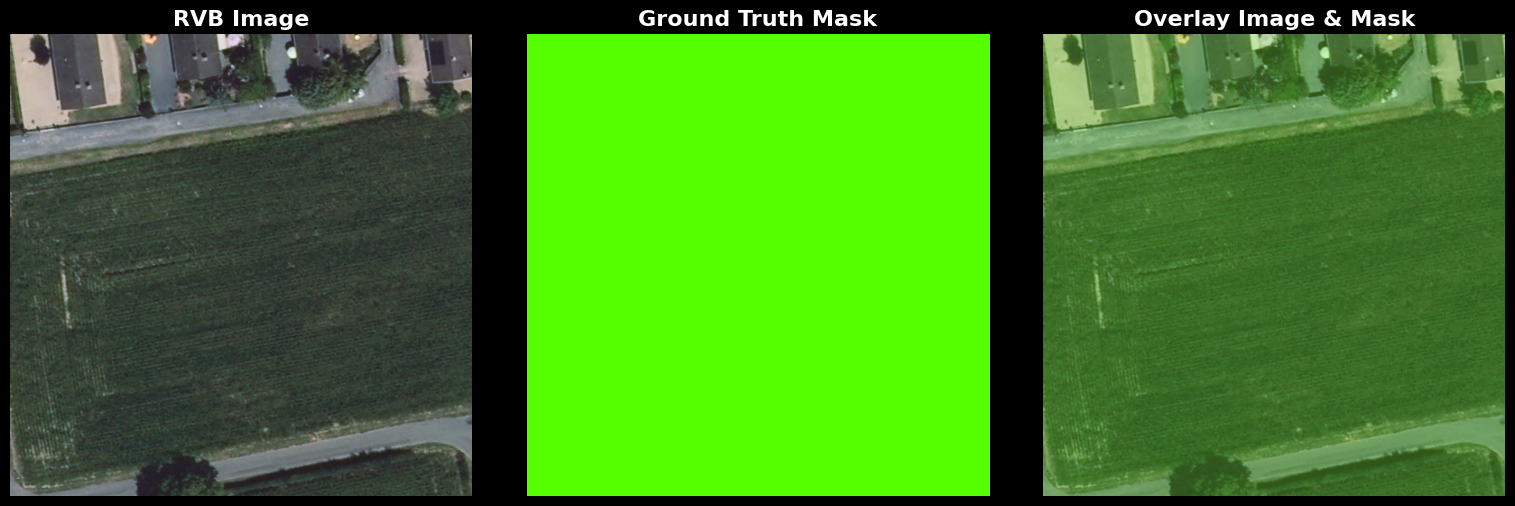

In [ ]:
display_samples(images, masks, nb_samples= 1)

#### Prepare

We create the `train_dataset` and `val_dataset` by using the `DFCDataset`, a custom class of `torch.utils.data.Dataset`

In [ ]:
from py_module.utils import Dataset_Flair1
from torch.utils.data import DataLoader


# Create dataset objects for each set
train_dataset = Dataset_Flair1(root_dir='C:\\Users\\frank\\Desktop\\Data\\train')
test_dataset = Dataset_Flair1(root_dir='C:\\Users\\frank\\Desktop\\Data\\test')
val_dataset = Dataset_Flair1(root_dir='C:\\Users\\frank\\Desktop\\Data\\val')


We can see how many examples are in each split by checking their length:

In [3]:
len(train_dataset), len(val_dataset), len(val_loader)

(70, 14, 4)

We define a correspondance of label and names:

In [5]:
dict_classes = {
1   : 'building',
2   : 'pervious surface',
3   : 'impervious surface',
4   : 'bare soil',
5   : 'water',
6   : 'coniferous',
7   : 'deciduous',
8   : 'brushwood',
9   : 'vineyard',
10  : 'herbaceous vegetation',
11  : 'agricultural land',
12  : 'plowed land',
13  : 'other'}

Our data is now ready to be used by the model. In the next section we load and configure the model. 

<a id='quickstart'></a>
## 3. Quick Start

#### Configure 

You can specify in the some hyperparameters in `train_config`  and `model_config` (cell below).

In [6]:
# Training configurations
model_config = {'img_size': 224,
                 'patch_size': 4,
                 'in_chans':5, 
                 'num_classes':13,
                 'embed_dim': 96, 
                 'depths':[2, 2, 2, 2],
                 'depths_decoder': [1, 2, 2, 2],
                 'num_heads' :[3, 6, 12, 24],
                 'window_size':7,
                  'mlp_ratio' :4.,
                    'qkv_bias' : True,
                    'qk_scale': None,
                 'drop_rate' :0.,
                'attn_drop_rate':0., 
                'drop_path_rate':0.1,
                 'norm_layer': nn.LayerNorm, 
                 'ape': False,
                'patch_norm': True,
                 'use_checkpoint' :False, 
                 'final_upsample' :"expand_first"
                }

train_config = {
    'input_channels': 5,
    'classifier_lr': 3e-6,
    'learning_rate': 0.001,
    'adam_betas': (0.9, 0.999), 
    'weight_decay': 0.001,
    'dataloader_workers': 4,
    'batch_size': 1,
    'epochs': 1
}

NameError: name 'nn' is not defined

#### Prepare model 

In [ ]:
from Transformer_SSL.models.swin_transformer import DoubleSwinTransformerDownstream
from utils import save_checkpoint_single_model, dotdictify
from Transformer_SSL.models import build_model


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu:0")

In [ ]:
from SwinUnet.vision_transformer import SwinUnet

model = SwinUnet(config=model_config, num_classes=model_config['num_classes'])

model = model.to(device)

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:8


c:\Users\frank\SSLTransformerRS\.venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---final upsample expand_first---


Define and initialise the loss for training.

In [ ]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=255, reduction="mean").to(device)

Initialise the selected optimizer. In this work we chose Adam optimizer. You can initialise any optimizer you want. 

In [ ]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=train_config['learning_rate'],
    betas=train_config['adam_betas'],
    weight_decay=train_config['weight_decay'],
)

We load the data (training and validation) using pytorch's dataloader 

In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, 
                          batch_size=4, 
                          shuffle=True)

test_loader = DataLoader(test_dataset, 
                         batch_size=4,
                         shuffle=False)

val_loader = DataLoader(val_dataset, 
                        batch_size=4, 
                        shuffle=False)

Everything is set and we are now ready to train our model:

In [ ]:
from utils import PixelwiseMetrics, AverageMeter

# Ensure necessary classes like ConfMatrix, PixelwiseMetrics are imported
# from utils import ConfMatrix, PixelwiseMetrics, generate_miou

num_classes = model_config['num_classes']

class EarlyStopping:
    """ Class for early stopping """
    def __init__(self, patience=6, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def train_segmentation_model(epochs, train_loader, val_loader, model, optimizer, criterion, num_classes):
    early_stopper = EarlyStopping(patience=6)
    best_val_loss = float('inf')
    best_model_wts = None

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses, train_metrics = [], PixelwiseMetrics(num_classes)

        for sample in tqdm(train_loader):

            x = sample[0].to(device)

            truth = sample[1].long().to(device)
            truth = torch.squeeze(truth, 1)
            
            optimizer.zero_grad()
            y_hat = model(x)
            
            loss = criterion(y_hat, truth)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            pred = torch.argmax(y_hat, dim=1)
            train_metrics.add_batch(truth, pred)

        # Calculate training statistics
        train_loss = np.mean(train_losses)
        train_acc = train_metrics.get_average_accuracy()

        # Validation Phase
        if epoch % 2 == 0:
            model.eval()
            val_losses, val_metrics = [], PixelwiseMetrics(num_classes)
            with torch.no_grad():
                for sample in tqdm(val_loader):
                    
                    x = sample[0].to(device)

                    y = sample[1].long().to(device)
                    y = torch.squeeze(y, 1)

                    y_hat = model(x)
                
                    loss = criterion(y_hat, y)

                    val_losses.append(loss.item())
                    pred = torch.argmax(y_hat, dim=1)
                    val_metrics.add_batch(y, pred)

            # Calculate validation statistics
            val_loss = np.mean(val_losses)
            val_acc = val_metrics.get_average_accuracy()

            # Imprimer les statistiques
            print(f'Epoch {epoch}: Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')


            # Save the best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_wts = model.state_dict()

            # Early stopping
            early_stopper(val_loss)
            if early_stopper.early_stop:
                print("Early stopping triggered")
                break

    # Save best model weights after training loop
    if best_model_wts:
        torch.save(best_model_wts, 'checkpoints\SwinUnet_S1_best_model.pth')
        print("Best model saved.")

    print("Training completed.")



ImportError: cannot import name 'PixelwiseMetrics' from 'utils' (c:\Users\frank\SSLTransformerRS\utils.py)

In [ ]:
train_segmentation_model(train_config['epochs'], train_loader, val_loader, model, optimizer, criterion, num_classes)

  0%|          | 0/986 [00:00<?, ?it/s]

: 

You can evaluate the model on one example by creating a model's instance, loading checkpoint's weights of the classifier saved during training, running it, and displaying the results:

In [ ]:
import matplotlib.pyplot as plt

# Create a new instance of the model
model = SwinUnet(model_config, num_classes=8)
model = model.to(device)

# Load checkpoint weights
model.load_state_dict(torch.load("checkpoints/SSwinUnet_S1_best_model.pth"))

# Prepare the input and feed it to the model for evaluation
img = torch.unsqueeze(val_dataset[2]['s1'], 0)
model.eval()
output = model(img)

# Reduce the batch dimension and take the class index with the highest probability for each pixel
output = torch.argmax(output, dim=1).squeeze(0)

# Create a subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the predicted segmentation map
axes[0].imshow(output.cpu().numpy())
axes[0].set_title('Predicted Segmentation Map')
axes[0].axis('off') 

# Display the ground truth segmentation map
ground_truth = val_dataset[2][train_config['target']].squeeze(0).cpu().numpy()
axes[1].imshow(ground_truth)
axes[1].set_title('Ground Truth Segmentation Map')
axes[1].axis('off')  # Turn off axes for better visibility

# Show the plots
plt.show()


In [ ]:
from utils import generate_miou, print_metrics, predict_and_save

truth_msk = 'C:\\Users\\frank\\Desktop\\data sentinel\\val\\ROIs0000_test\\dfc_0'
pred_msk  = 'C:\\Users\\frank\\resultats\\SwinUnet_S1'

predict_and_save(truth_msk, pred_msk, model, device='cuda')

mIou, ious = generate_miou(truth_msk, pred_msk)
print_metrics(mIou, ious)